# Knowledge distillation
In this notebook, we will try to distill the knowledge of a Vision Transformer into a MLP Mixer.

##0. Downloads and imports

In [ ]:
#@title Downloads
!pip install -q transformers datasets[vision] pytorch-lightning
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Imports

# general imports
from typing import *
from google.colab import drive
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

# pytorch imports
import torchvision
import transformers
#from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch
import numpy as np
import einops
import torch.nn as nn
import torch.nn.functional as F

device : str = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
#@title Move to the project folder
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive

if not os.path.exists("ViT2MLP"):
  os.mkdir("ViT2MLP")

%cd ViT2MLP

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/ViT2MLP


In [ ]:
#@title Download the datasets
# TODO need to download it
#imagenet = torchvision.datasets.ImageNet(root = ".",split = "val")

cifar100_test = torchvision.datasets.CIFAR100(root = ".", train = False, download = True)
cifar100_train = torchvision.datasets.CIFAR100(root = ".", train = True, download = True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#@title Visualization function
def visualize(datapoint : int, dataset : torchvision.datasets):
    image, label = dataset[datapoint]
    plt.title(f"Ground truth: {dataset.classes[label]}")
    plt.imshow(image)

##1. Code for the pre-trained transformer

References:
- [main transformer docs](https:huggingface.co/docs/transformers/index) 
- [ViT Docs](https://huggingface.co/docs/transformers/model_doc/vit)
- [lighting finetuning example](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/VisionTransformer)

### Example of transformer model

Load ViT finetuned on Imagenet1k or CIFAR100. To load the non fine-tuned version use **"google/vit-base-patch16-224-im21k"**

In [ ]:
#@title Load the model
cifar100_vit = "Ahmed9275/Vit-Cifar100"
imagenet1k_vit = "google/vit-base-patch16-224"
tuned_on : str = "cifar100" #@param['cifar100', 'imagenet1k']
if tuned_on == "cifar100":
    model_str = cifar100_vit
else:
    model_str = imagenet1k_vit


feature_extractor = transformers.ViTFeatureExtractor.from_pretrained(model_str)

transformer_model = transformers.ViTForImageClassification.from_pretrained(model_str).to(device)

In [ ]:
#@title Function to predict - a questa funzione dovremmo anche passare il modello :)
def predict(image, only_label : bool = False) -> str:
    inputs = feature_extractor(image, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = transformer_model(**inputs).logits

    # model predicts one of the 1000 ImageNet classes
    predicted_label : int = logits.argmax(-1).item()
    if only_label:
        return predicted_label
    return transformer_model.config.id2label[predicted_label]


Predicted: lion


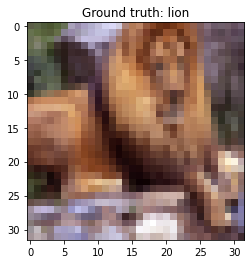

In [ ]:
#@title Qualitative comparison with ground truth {run : "auto"}
datapoint_number : int = 1200 #@param{type:"integer"}

dataset = cifar100_test if tuned_on == "cifar100" else imagenet1k
try:
    visualize(datapoint_number, dataset)
    print(f"Predicted: {predict(dataset[datapoint_number][0])}")
except IndexError:
    print(f"The dataset max index is {len(dataset)-1}")


In [ ]:
#@title Quantitative result: Accuracy
correct = 0
for i in tqdm(range(len(dataset))):
    pr_label = predict(dataset[i][0], only_label=True)
    gt_label = dataset[i][1]
    if pr_label == gt_label:
        correct += 1
accuracy = round(correct*100 / len(dataset),2)
print(f"The accuracy of the model for the dataset {tuned_on} is: {accuracy}%")

##2. Code for MLP mixer

In [ ]:
#tentative pytorch implementation for https://github.com/google-research/vision_transformer/blob/main/vit_jax/models_mixer.py
#to include: apache license lol

class MlpBlock(nn.Module):
  """
  MlpBlock for MixerBlock
  """

  def __init__(self, dim, mlp_dim):
    super().__init__()
    #dense implementation only has out features specified, need to check input dim
    self.mlp1 = nn.Linear(in_features=dim, out_features = mlp_dim)
    self.mlp2 = nn.Linear(in_features=mlp_dim, out_features = dim)
    self.activation = F.gelu

  def forward(self, x):
    y = self.mlp1(x)
    y = self.activation(y)
    y = self.mlp2(y)
    return y

class MixerBlock(nn.Module):
  """
  Mixer block for the mlp mixer
  """

  def __init__(self, num_patches, hidden_dim,
               tokens_mlp_dim, channels_mlp_dim):
    super().__init__()
    self.layer_norm = torch.nn.LayerNorm([num_patches, hidden_dim])
    self.mlpblock_token_mixer = MlpBlock(num_patches, tokens_mlp_dim)
    self.mlpblock_channel_mixer = MlpBlock(hidden_dim, channels_mlp_dim)

  def forward(self,x):
    y = self.layer_norm(x)
    y = np.swapaxes(y,1,2)
    y = self.mlpblock_token_mixer(y)
    y = np.swapaxes(y,1,2)
    x = x + y
    y = self.layer_norm(x)
    return x + self.mlpblock_channel_mixer(y)

class MlpMixer(nn.Module):
  """
  Mixer architecture
  hidden_dim : number of hidden channels
  img_size : the height/width of the image
  patches_size : dimension of patches, must be a multiple of img_size
  num_blocks : number of mixer blocks
  hidden_dim : hidden dimensionality
  tokens_mlp_dim : dimensionality of token mixer
  channels_mlp_dim : dimensionality of channel mixer
  """

  def __init__(self, hidden_dim : int, patches_size : int,
               num_blocks: int, tokens_mlp_dim : int,
               channels_mlp_dim : int, num_classes: int,
               input_channels : int, img_size :int):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_blocks = num_blocks
    self.num_classes = num_classes
    self.num_patches = int((img_size / patches_size)*2)
    #Per patch fully connected
    self.stem = nn.Conv2d(in_channels = input_channels, 
                          out_channels = self.hidden_dim,
                          kernel_size = (patches_size,patches_size),
                          stride = patches_size)
    self.mixer_blocks = nn.ModuleList([]) 
    for _ in range(num_blocks):
      self.mixer_blocks.append(MixerBlock(num_patches = self.num_patches,
                                  hidden_dim = hidden_dim,
                                  tokens_mlp_dim = tokens_mlp_dim,
                                  channels_mlp_dim = channels_mlp_dim))
    self.layer_norm = torch.nn.LayerNorm([self.num_patches, hidden_dim])
    #What is kernel init? Does it initialize everything to 0?
    self.fc = nn.Linear(in_features = hidden_dim, out_features = self.num_classes)
    self.softmax = F.softmax

  def forward(self, inputs, *, train):
    del train
    x = self.stem(inputs)
    x = einops.rearrange(x, 'n c h w -> n h w c')
    x = einops.rearrange(x, 'n h w c -> n (h w) c')
    for mixer_block in self.mixer_blocks:
      x = mixer_block(x)
    x = self.layer_norm(x)
    x = x.mean(dim = 1)
    if self.num_classes:
      #add classification layer if num classes is specified
      x = self.softmax(self.fc(x), dim=-1)
    return x

In [ ]:
student = MlpMixer(hidden_dim = 512,
               patches_size = 16,
               num_blocks = 8,
               tokens_mlp_dim = 256,
               channels_mlp_dim = 2048,
               num_classes = 100,
               input_channels = 3,
               img_size = 32)
print(student)
parameters = filter(lambda p: p.requires_grad, student.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Trainable Parameters: %.3fM' % parameters)

MlpMixer(
  (stem): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
  (mixer_blocks): ModuleList(
    (0): MixerBlock(
      (layer_norm): LayerNorm((4, 512), eps=1e-05, elementwise_affine=True)
      (mlpblock_token_mixer): MlpBlock(
        (mlp1): Linear(in_features=4, out_features=256, bias=True)
        (mlp2): Linear(in_features=256, out_features=4, bias=True)
      )
      (mlpblock_channel_mixer): MlpBlock(
        (mlp1): Linear(in_features=512, out_features=2048, bias=True)
        (mlp2): Linear(in_features=2048, out_features=512, bias=True)
      )
    )
    (1): MixerBlock(
      (layer_norm): LayerNorm((4, 512), eps=1e-05, elementwise_affine=True)
      (mlpblock_token_mixer): MlpBlock(
        (mlp1): Linear(in_features=4, out_features=256, bias=True)
        (mlp2): Linear(in_features=256, out_features=4, bias=True)
      )
      (mlpblock_channel_mixer): MlpBlock(
        (mlp1): Linear(in_features=512, out_features=2048, bias=True)
        (mlp2): Linear(in_feat

In [ ]:
import torchvision
t = torchvision.transforms.functional.pil_to_tensor(dataset[0][0]).float().unsqueeze(0)

print(t.shape)

pred = student(t,train=False)

print(pred.sum())

torch.Size([1, 3, 32, 32])
tensor(1., grad_fn=<SumBackward0>)


##3. Distillation

### 3.1 Computing labels


First of all we want to compute once and for all the teacher scores of the images:

In [ ]:
cifar100_train_tensors = torchvision.datasets.CIFAR100(root = ".", train = True, download = True, transform=torchvision.transforms.functional.pil_to_tensor)

Files already downloaded and verified


In [ ]:
def compute_scores(dataset : torch.utils.data.Dataset,
                   teacher : torch.nn.Module, 
                   teacher_extractor : Any, # a feature extractor
                   num_classes : int) -> torch.Tensor:
    teacher_label = torch.zeros(len(dataset), num_classes)
    for i,(image,_) in tqdm(enumerate(dataset)):
        features = teacher_extractor(image,return_tensors="pt").to(device)
        with torch.no_grad():
            label = teacher(**features).logits
        teacher_label[i,:] = label
    return teacher_label

In [ ]:
#tl = compute_scores(cifar100_train_tensors,transformer_model,feature_extractor,100)

50000it [17:30, 47.60it/s]


### 3.2 Creating custom datasets

In [ ]:
class DistillDataset(torch.utils.data.Dataset):
    '''
    A dataset for the distillation training.
    This dataset wraps the original dataset toghether with the teacher ground truth.
    '''
    def __init__(self, 
                 original_dataset : torch.utils.data.Dataset,
                 teacher_label_path : Path = None,
                 teacher_model : torch.nn.Module = None,
                 teacher_extractor : Any = None,
                 save : bool = False
                 ):
        assert(teacher_label_path is not None or teacher_model is not None)
        super().__init__()
        self.dataset = original_dataset
        try:
            with open(teacher_label_path, "rb") as dl:
                self.teacher_label = torch.load(dl)
        except:
            self.teacher_label = compute_scores(self.dataset, 
                                                teacher_model,
                                                teacher_extractor,
                                                len(self.dataset.classes)
                                                )
            if save:
                #create directory if it does not exist
                if not os.path.exists(teacher_label_path):
                   os.mkdirs(teacher_label_path)

                with open(teacher_label_path, "wb") as tl:
                    torch.save(self.teacher_label,tl)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        return self.dataset[index][0], self.dataset[index][1] , self.teacher_label[index]

In [ ]:
dataset = DistillDataset(cifar100_train_tensors, 
                         "teacher_labels/cifar100.pt"
                         )

In [ ]:
!wget --user Ale99 --password Vitmlpmixer99 https://huggingface.co/datasets/imagenet-1k/resolve/main/data/val_images.tar.gz

In [ ]:
!mkdir imagenet_val
!tar -xvf val_images.tar.gz -C imagenet_val

### 3.3 Training the student

In [ ]:
#TODO: reorganize

from torch.utils.data import DataLoader
from torch.optim import SGD


#pinnare memoria?
train_dl = DataLoader(dataset, batch_size = 512, shuffle = True, num_workers = 0,
                      pin_memory = False)

criterion1 = nn.CrossEntropyLoss()
optimizer = SGD(student.parameters(), lr=0.0025, momentum=0.75)

for i in range(5):
  for iteration, data in tqdm(enumerate(train_dl)):

    optimizer.zero_grad()

    teacher_gt = F.softmax(data[2], dim=-1)
    hard_gt = (teacher_gt.argmax(-1)).float()
    preds = student(data[0].float(), train=False)
    hard_labels = (preds.argmax(-1)).float()

    loss = criterion1(preds, teacher_gt) 

    if iteration % 20 == 0:
      print("Current batch loss: ",loss)

    loss.backward()
    optimizer.step()


0it [00:00, ?it/s]

Current batch loss:  tensor(4.6001, grad_fn=<DivBackward1>)


20it [02:26,  6.83s/it]

Current batch loss:  tensor(4.5986, grad_fn=<DivBackward1>)


40it [04:43,  6.76s/it]

Current batch loss:  tensor(4.5787, grad_fn=<DivBackward1>)


60it [06:57,  6.65s/it]

Current batch loss:  tensor(4.5856, grad_fn=<DivBackward1>)


80it [09:13,  6.72s/it]

Current batch loss:  tensor(4.5838, grad_fn=<DivBackward1>)


98it [11:12,  6.86s/it]
0it [00:00, ?it/s]

Current batch loss:  tensor(4.5910, grad_fn=<DivBackward1>)


20it [02:14,  6.66s/it]

Current batch loss:  tensor(4.5912, grad_fn=<DivBackward1>)


40it [04:28,  6.67s/it]

Current batch loss:  tensor(4.5804, grad_fn=<DivBackward1>)


60it [06:43,  6.67s/it]

Current batch loss:  tensor(4.5810, grad_fn=<DivBackward1>)


80it [08:56,  6.73s/it]

Current batch loss:  tensor(4.5958, grad_fn=<DivBackward1>)


98it [10:58,  6.72s/it]
0it [00:00, ?it/s]

Current batch loss:  tensor(4.5894, grad_fn=<DivBackward1>)


20it [02:21,  7.08s/it]

Current batch loss:  tensor(4.5964, grad_fn=<DivBackward1>)


40it [04:43,  6.98s/it]

Current batch loss:  tensor(4.6022, grad_fn=<DivBackward1>)


60it [07:03,  6.97s/it]

Current batch loss:  tensor(4.5976, grad_fn=<DivBackward1>)


80it [09:24,  6.96s/it]

Current batch loss:  tensor(4.5953, grad_fn=<DivBackward1>)


98it [11:28,  7.03s/it]
0it [00:00, ?it/s]

Current batch loss:  tensor(4.5923, grad_fn=<DivBackward1>)


20it [02:24,  7.18s/it]

Current batch loss:  tensor(4.5854, grad_fn=<DivBackward1>)


40it [04:45,  7.08s/it]

Current batch loss:  tensor(4.5894, grad_fn=<DivBackward1>)


60it [07:07,  7.01s/it]

Current batch loss:  tensor(4.5984, grad_fn=<DivBackward1>)


80it [09:26,  6.88s/it]

Current batch loss:  tensor(4.5894, grad_fn=<DivBackward1>)


98it [11:31,  7.05s/it]
0it [00:00, ?it/s]

Current batch loss:  tensor(4.5894, grad_fn=<DivBackward1>)


20it [02:21,  7.54s/it]

Current batch loss:  tensor(4.5914, grad_fn=<DivBackward1>)


40it [04:39,  6.94s/it]

Current batch loss:  tensor(4.5890, grad_fn=<DivBackward1>)


60it [07:00,  7.10s/it]

Current batch loss:  tensor(4.5906, grad_fn=<DivBackward1>)


80it [09:20,  6.97s/it]

Current batch loss:  tensor(4.5958, grad_fn=<DivBackward1>)


98it [11:26,  7.00s/it]
